# Algorithme principal, qui permet de tester différents classifier avec différentes features

In [2]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt
from FormeAwayHome import add_win_streak_to_dataset
from sklearn.metrics import plot_confusion_matrix

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion, Pipeline, make_union
from sklearn.preprocessing import FunctionTransformer

In [3]:
#Création de la pipeline qui selectionne les features spécifiées

def basic(X):
    return X[['HTS',
       'HTST', 'HTW', 'HTD', 'HTL', 'HTG','HTF', 'HTY', 'HTR', 'ATS', 'ATST',
       'ATW', 'ATD', 'ATL', 'ATG','ATF', 'ATY', 'ATR']]

def basic_dataset(X):
    return X[['HTS',
       'HTST', 'HTW', 'HTD', 'HTL', 'HTG', 'ATS', 'ATST',
       'ATW', 'ATD', 'ATL', 'ATG']]

def foul(X):
    return X[['HTF', 'HTY', 'HTR','ATF', 'ATY', 'ATR']]

def budget(X):
    return X[['HB', 'AB']]

def fifa(X):
    return X[['HATT', 'HMIL', 'HDEF', 'AATT', 'AMIL', 'ADEF']]

def streak(X):
    return X[['HomeTeamStreak_AtHome','AwayTeamStreak_AtHome','HomeTeamStreak_AtAway','AwayTeamStreak_AtAway']]

def public(X):
    return X[['Home attendance','Away attendance']]

def ftr(X):
    return X['FTR']

def best_features(X):
    return X[['HTS',
       'HTST', 'HTW', 'HTD', 'HTL', 'HTG','HTF', 'HTY', 'HTR', 'ATS', 'ATST',
       'ATW', 'ATD', 'ATL', 'ATG','ATF', 'ATY', 'ATR','HB', 'AB','Home attendance','Away attendance']]
# pipeline to get all tfidf and word count for first column

pipeline_main_dataset = Pipeline([('main_selection', FunctionTransformer(basic_dataset))])
pipeline_foul = Pipeline([('foul_selection', FunctionTransformer(foul))])
pipeline_budget = Pipeline([('budget_selection', FunctionTransformer(budget))])
pipeline_FIFA = Pipeline([('FIFA_selection', FunctionTransformer(fifa))])
pipeline_streak = Pipeline([('streak_selection', FunctionTransformer(streak))])
pipeline_public = Pipeline([('budget_selection', FunctionTransformer(public))])
pipeline_lables = Pipeline([('labels_selection', FunctionTransformer(ftr))])


def create_X_y(datafram,main_data = True, foul=True,budget=False, fifa = False, streak = False, public= False):
    L=[]
    if main_data:
        L.append(('main_data',pipeline_main_dataset))
    if foul:
        L.append(('foul',pipeline_foul))
    if budget:
        L.append(('budget',pipeline_budget))
    if fifa:
        L.append(('fifa',pipeline_FIFA))
    if streak:
        L.append(('streak',pipeline_streak))
    if public:
        L.append(('public',pipeline_public))
    final_transformer = FeatureUnion(L)

    return final_transformer.fit_transform(datafram),pipeline_lables.fit_transform(datafram)

In [4]:
#Lecture des datasets

df0 = pd.read_csv('DatasetsFeatures/2015_2016_features.csv')
df1 = pd.read_csv('DatasetsFeatures/2016_2017_features.csv')
df2 = pd.read_csv('DatasetsFeatures/2017_2018_features.csv')
df3 = pd.read_csv('DatasetsFeatures/2018_2019_features.csv')

df0 = df0[10:]
df1 = df1[10:]
df2 = df2[50:]
df3 = df3[50:]

df0 = df0.dropna()
df1 = df1.dropna()
df2 = df2.dropna()
df3 = df3.dropna()

df1 = df1.reset_index(drop = True)
df2 = df2.reset_index(drop = True)
df3 = df3.reset_index(drop = True)
df0 = df0.reset_index(drop = True)
df0 = df0.astype({'FTR': 'int64'})

frames = [df0,df1]
df = pd.concat(frames,ignore_index=True)

On veut tester quelle est la meileure combinaison de features. Pour cela on doit d'abord déterminer toutes les combinaisons possibles ( ensemble des parties de {1,2,3,4} ).

In [13]:
def partiesliste(seq):
    p = []
    i, imax = 0, 2**len(seq)-1
    while i <= imax:
        s = []
        j, jmax = 0, len(seq)-1
        while j <= jmax:
            if (i>>j)&1 == 1:
                s.append(seq[j])
            j += 1
        p.append(s)
        i += 1 
    return p

dico = {1:'budget',2:'fifa',3:'streak',4:'public'}
dico_f={'[]':'[]'}
parties = partiesliste([1,2,3,4])
parties.pop(0)
for i in parties:
    aux = []
    for j in i:
        aux.append(dico[j])
    dico_f[str(i)]=str(aux)

def teste_tout(df,df2,n_forest):
    L = partiesliste([1,2,3,4])
    
    partition_score = {}
    #budget=False, fifa = False, streak = False, public= False
    for i in range(len(L)):
        budget = False
        fifa   = False
        streak = False
        public = False
        if 1 in L[i]:
            budget=True
        if 2 in L[i]:
            fifa=True
        if 3 in L[i]:
            streak=True
        if 4 in L[i]:
            public=True

        X_train,y_train = create_X_y(df ,budget = budget,fifa = fifa,streak = streak,public = public)
        X_test,y_test   = create_X_y(df2,budget = budget,fifa = fifa,streak = streak,public = public)

        scores = []
        for _ in range(1,n_forest):
            clf = RandomForestClassifier(n_estimators=300)
            clf.fit(X_train,y_train)
            scores.append(clf.score(X_test,y_test))
        print("score moyen avec : dataset initial +",dico_f[str(L[i])],':',sum(scores)/len(scores))

        partition_score[str(L[i])] = sum(scores)/len(scores)
    
    return partition_score

In [14]:
n=3
power = teste_tout(df,df2,n)

score moyen avec : dataset initial + [] : 0.5121212121212122
score moyen avec : dataset initial + ['budget'] : 0.5212121212121212
score moyen avec : dataset initial + ['fifa'] : 0.5196969696969697
score moyen avec : dataset initial + ['budget', 'fifa'] : 0.5212121212121212
score moyen avec : dataset initial + ['streak'] : 0.509090909090909
score moyen avec : dataset initial + ['budget', 'streak'] : 0.5393939393939393
score moyen avec : dataset initial + ['fifa', 'streak'] : 0.5136363636363637
score moyen avec : dataset initial + ['budget', 'fifa', 'streak'] : 0.5257575757575758
score moyen avec : dataset initial + ['public'] : 0.5151515151515151
score moyen avec : dataset initial + ['budget', 'public'] : 0.5606060606060606
score moyen avec : dataset initial + ['fifa', 'public'] : 0.5227272727272727
score moyen avec : dataset initial + ['budget', 'fifa', 'public'] : 0.543939393939394
score moyen avec : dataset initial + ['streak', 'public'] : 0.5227272727272727
score moyen avec : datase

La meilleure combinaison de features semble donc être budget + public

In [ ]:
Voici maintenant les tests des différents classifier


In [25]:
#%%Meilleure combinaison de features

X_train,y_train = create_X_y(df ,budget=True,public=True,fifa=False,streak=False)
X_test,y_test   = create_X_y(df2,budget=True,public=True,fifa=False,streak=False)

test du Classifier Random Forest
score : 0.5424242424242425


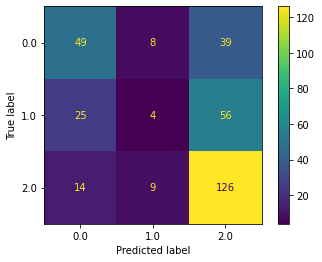

In [26]:
print("test du Classifier Random Forest")
clf = RandomForestClassifier(n_estimators=300)
clf.fit(X_train,y_train)
print("score :",clf.score(X_test,y_test))
plot_confusion_matrix(clf,X_test,y_test)



Test du Classifier Gradient Boosting
score : 0.5060606060606061


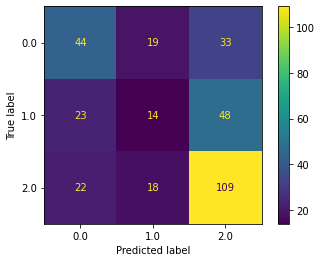

In [21]:
print("Test du Classifier Gradient Boosting")
clf = GradientBoostingClassifier(max_depth=5, n_estimators=300,learning_rate=0.05)
clf.fit(X_train,y_train)
print("score :",clf.score(X_test,y_test))
plot_confusion_matrix(clf,X_test,y_test)


Test du Classifier Arbre de décision
score : 0.3939393939393939


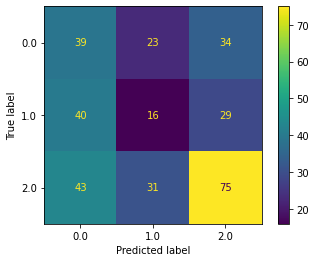

In [20]:
print("Test du Classifier Arbre de décision")
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)
print("score :",clf.score(X_test,y_test))
plot_confusion_matrix(clf,X_test,y_test)

Test du Classifier Regression logistique
score : 0.5242424242424243


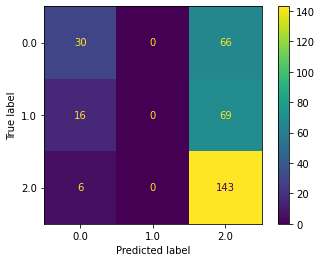

In [27]:
print("Test du Classifier Regression logistique")
clf = LogisticRegression()
clf.fit(X_train,y_train)
print("score :",clf.score(X_test,y_test))
plot_confusion_matrix(clf,X_test,y_test)

Test du Classifier SVM
score : 0.5242424242424243


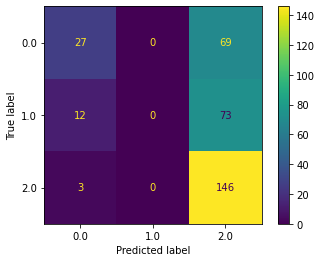

In [23]:
print("Test du Classifier SVM")
clf = SVC()
clf.fit(X_train,y_train)
print("score :",clf.score(X_test,y_test))
plot_confusion_matrix(clf,X_test,y_test)

Le meilleur classifier semble être Random Forest, qui semble faire de très bon score avec 300 arbres. Nous utiliserons ce classifier par la suite.

Voici l'importance des différentes features dans le modèle :

0.5333333333333333


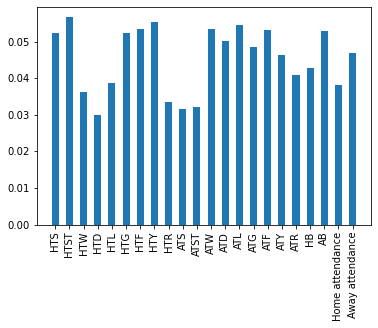

In [28]:
#%% plot features importances for random forest (!!! certains classifers n'ont pas de feature importances)
clf = RandomForestClassifier(n_estimators=300)
clf.fit(X_train,y_train)
print(clf.score(X_test,y_test))

plt.bar(x=best_features(df).columns,height=clf.feature_importances_,width=0.5,bottom=None, align='center')
plt.xticks(range(len(best_features(df).columns)), best_features(df).columns, rotation='vertical')
plt.show()

Nous allons maitenant montrer quelques prédictions ainsi que le résultat réel du match afin de voir quelles sont les réussites de l'algorithme, mais aussi où fait-il des erreurs.

In [29]:
prediction = clf.predict(X_test)

for idx in range(len(y_test)):
    win_team = 0
    pred_team = 0
    if y_test[idx]==2:
        win_team=df2['HomeTeam'].iloc[idx]
    if y_test[idx]==1:
        win_team = "Draw"
    if y_test[idx]==0:
        win_team=df2['AwayTeam'].iloc[idx]
    
    if prediction[idx]==0:
        pred_team = df2['AwayTeam'].iloc[idx]
    if prediction[idx]==2:
        pred_team = df2['HomeTeam'].iloc[idx]
    if prediction[idx]==1:
        pred_team = 'Draw'

    print(df2['HomeTeam'].iloc[idx]+" - "+df2['AwayTeam'].iloc[idx]+" | algo predit : "+pred_team+" | le vrai résultat est : "+win_team+"\n")


go predit : Rennes | le vrai résultat est : Rennes

Angers - Paris SG | algo predit : Paris SG | le vrai résultat est : Paris SG

Monaco - Guingamp | algo predit : Monaco | le vrai résultat est : Monaco

Montpellier - Amiens | algo predit : Montpellier | le vrai résultat est : Draw

Nantes - Toulouse | algo predit : Nantes | le vrai résultat est : Nantes

Troyes - Strasbourg | algo predit : Troyes | le vrai résultat est : Troyes

Marseille - Caen | algo predit : Marseille | le vrai résultat est : Marseille

Metz - Lille | algo predit : Lille | le vrai résultat est : Lille

Nice - Dijon | algo predit : Nice | le vrai résultat est : Nice

St Etienne - Lyon | algo predit : Lyon | le vrai résultat est : Lyon

Amiens - Monaco | algo predit : Monaco | le vrai résultat est : Draw

Lille - St Etienne | algo predit : Draw | le vrai résultat est : Lille

Dijon - Troyes | algo predit : Dijon | le vrai résultat est : Dijon

Guingamp - Angers | algo predit : Guingamp | le vrai résultat est : Draw



Voici maintenant les prédictions avec les probabilités de chaque issue, qui pourraient être utilisées pour conseiller le parieur sans risquer de prendre une décision tranchée.

In [30]:
proba_predic = clf.predict_proba(X_test)
for idx,i in enumerate(y_test):
    win_team = 0
    if y_test[idx]==2:
        win_team=df2['HomeTeam'].iloc[idx]
    if y_test[idx]==1:
        win_team = "Draw"
    if y_test[idx]==0:
        win_team=df2['AwayTeam'].iloc[idx]
    aux = np.flip(proba_predic[idx])
    print(df2['HomeTeam'].iloc[idx]+" - "+df2['AwayTeam'].iloc[idx]+" // prédictions: "+df2['HomeTeam'].iloc[idx]+'= '+str(round(aux[0],3))+" | Draw= "+str(round(aux[1],3))+ " | "+df2['AwayTeam'].iloc[idx]+"= "+str(round(aux[2],3))+" // Le vrai résultat est "+win_team+"\n")


 résultat est Draw

Nantes - Paris SG // prédictions: Nantes= 0.153 | Draw= 0.303 | Paris SG= 0.543 // Le vrai résultat est Paris SG

St Etienne - Toulouse // prédictions: St Etienne= 0.49 | Draw= 0.393 | Toulouse= 0.117 // Le vrai résultat est St Etienne

Bordeaux - Caen // prédictions: Bordeaux= 0.55 | Draw= 0.203 | Caen= 0.247 // Le vrai résultat est Caen

Marseille - Strasbourg // prédictions: Marseille= 0.62 | Draw= 0.193 | Strasbourg= 0.187 // Le vrai résultat est Marseille

Monaco - Nice // prédictions: Monaco= 0.58 | Draw= 0.267 | Nice= 0.153 // Le vrai résultat est Draw

Amiens - Montpellier // prédictions: Amiens= 0.38 | Draw= 0.253 | Montpellier= 0.367 // Le vrai résultat est Draw

Angers - Troyes // prédictions: Angers= 0.423 | Draw= 0.273 | Troyes= 0.303 // Le vrai résultat est Angers

Guingamp - Lyon // prédictions: Guingamp= 0.153 | Draw= 0.197 | Lyon= 0.65 // Le vrai résultat est Lyon

Lille - Rennes // prédictions: Lille= 0.4 | Draw= 0.423 | Rennes= 0.177 // Le vrai ré

Pour nous rendre compte de l'efficacité de nos prédictions sur un parieur, nous allons simuler une année de paris en suivant à la lettre toutes nos prédictions. On pari exactement 10 euros sur chaque matchs.

Voici le résultat sur l'année 2017-2018 sur le site bet 365

On fait la simulation sur plusieurs forêts, car la génération de ce modèle est liée à l'aléatoire, ainsi les résultats varient légèrement autour d'un score moyen.

In [32]:
#récupération des cotes sur bet365

df2_cotes_raw = pd.read_csv('../DataSets/2017_2018.csv')
df2_cote = pd.DataFrame()
df2_cote['B365H']=df2_cotes_raw['B365H']
df2_cote['B365D']=df2_cotes_raw['B365D']
df2_cote['B365A']=df2_cotes_raw['B365A']

df2_cote = df2_cote.iloc[50:]
df2_cote = df2_cote.reset_index(drop=True)

In [33]:
def simule_annee_pari(classifier, df_cote_test, X_test, y_test, basebet=10):
    bankroll = 0
    predictions = classifier.predict(X_test)
    for i in range(len(y_test)):
        if predictions[i]==y_test[i]:
            if predictions[i]==2:
                bankroll+=basebet*df_cote_test['B365H'].iloc[i]
            if predictions[i]==1:
                bankroll+=basebet*df_cote_test['B365D'].iloc[i]
            if predictions[i]==0:
                bankroll+=basebet*df_cote_test['B365A'].iloc[i]
        
    return (bankroll-len(y_test)*basebet)

for i in range(10):
    clf = RandomForestClassifier(n_estimators=300)
    clf.fit(X_train,y_train)
    print("Forest n°"+str(i)+" - mise de 10 € sur chaque paris - gain final : "+str(simule_annee_pari(clf, df2_cote,X_test,y_test))+" €") 

Forest n°0 - mise de 10 € sur chaque paris - gain final : 186.20000000000255 €
Forest n°1 - mise de 10 € sur chaque paris - gain final : 170.00000000000227 €
Forest n°2 - mise de 10 € sur chaque paris - gain final : 210.00000000000227 €
Forest n°3 - mise de 10 € sur chaque paris - gain final : 149.4000000000019 €
Forest n°4 - mise de 10 € sur chaque paris - gain final : 186.00000000000273 €
Forest n°5 - mise de 10 € sur chaque paris - gain final : 246.7000000000021 €
Forest n°6 - mise de 10 € sur chaque paris - gain final : 131.9000000000019 €
Forest n°7 - mise de 10 € sur chaque paris - gain final : 266.10000000000264 €
Forest n°8 - mise de 10 € sur chaque paris - gain final : 78.60000000000218 €
Forest n°9 - mise de 10 € sur chaque paris - gain final : 322.70000000000255 €
